# Classifiez automatiquement des biens de consommation : 
*Notebook mission 1 - techniques traitement de texte*

**Etudiez la faisabilité d'un moteur de classification d'articles**

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégo

Objectif : Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image comme dans l’illustration ci-dessous.rie.

In [3]:
# fonction personnelle pour le pré traitement des données textuelles
import pre_treatment_text as ptt

import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

import wordcloud
from wordcloud import WordCloud

import timeit

from collections import defaultdict
from collections import Counter

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("nltk version", nltk.__version__)
print("wordcloud version", wordcloud.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
nltk version 3.8.1
wordcloud version 1.9.4


## 1 - Prétraitement et analyse des données textes

### 1.1 - Prétraitement des données textes de la description

Il s'agit de réaliser le pré traitement sur la description des articles.

#### Charger les données textes

In [5]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [6]:
data.shape

(1050, 15)

Regardons les valeurs manquantes :

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Tous les articles ont une description et un product_category_tree.

Regardons les doublons :

In [10]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Il n'y a pas de doublon.

#### Exploration des descriptions : tokenisation et analyse des fréquences

In [13]:
# tokenizer pour conserver uniquement les caractères alphanumériques
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize(data.iloc[1]['description'])

['Specifications',
 'of',
 'Sathiyas',
 'Cotton',
 'Bath',
 'Towel',
 '3',
 'Bath',
 'Towel',
 'Red',
 'Yellow',
 'Blue',
 'Bath',
 'Towel',
 'Features',
 'Machine',
 'Washable',
 'Yes',
 'Material',
 'Cotton',
 'Design',
 'Self',
 'Design',
 'General',
 'Brand',
 'Sathiyas',
 'Type',
 'Bath',
 'Towel',
 'GSM',
 '500',
 'Model',
 'Name',
 'Sathiyas',
 'cotton',
 'bath',
 'towel',
 'Ideal',
 'For',
 'Men',
 'Women',
 'Boys',
 'Girls',
 'Model',
 'ID',
 'asvtwl322',
 'Color',
 'Red',
 'Yellow',
 'Blue',
 'Size',
 'Mediam',
 'Dimensions',
 'Length',
 '30',
 'inch',
 'Width',
 '60',
 'inch',
 'In',
 'the',
 'Box',
 'Number',
 'of',
 'Contents',
 'in',
 'Sales',
 'Package',
 '3',
 'Sales',
 'Package',
 '3',
 'Bath',
 'Towel']

In [14]:
# Application de la fonction
freq, stats_df, corpora = ptt.freq_stats_for_description(data)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                                    total  unique
Elegance Polyester Multicolor Abstract Eyelet D...    236     132
Sathiyas Cotton Bath Towel                             74      48
Eurospa Cotton Terry Face Towel Set                   216     124
SANTOSH ROYAL FASHION Cotton Printed King sized...    143      73
Jaipur Print Cotton Floral King sized Double Be...    213     111
...                                                   ...     ...
Oren Empower Extra Large Self Adhesive Sticker        429     145
Wallmantra Large Vinyl Sticker Sticker                290     101
Uberlyfe Extra Large Pigmented Polyvinyl Films ...     37      29
Wallmantra Medium Vinyl Sticker Sticker                31      25
Uberlyfe Large Vinyl Sticker                           29      25

[1050 rows x 2 columns]


Regardons le résultat pour un article particulier :

In [16]:
# Exemple d'accès aux fréquences des mots pour une image spécifique
print(freq["Sathiyas Cotton Bath Towel"].most_common())

[('bath', 6), ('towel', 6), ('sathiyas', 3), ('cotton', 3), ('3', 3), ('of', 2), ('red', 2), ('yellow', 2), ('blue', 2), ('design', 2), ('model', 2), ('inch', 2), ('in', 2), ('sales', 2), ('package', 2), ('specifications', 1), ('features', 1), ('machine', 1), ('washable', 1), ('yes', 1), ('material', 1), ('self', 1), ('general', 1), ('brand', 1), ('type', 1), ('gsm', 1), ('500', 1), ('name', 1), ('ideal', 1), ('for', 1), ('men', 1), ('women', 1), ('boys', 1), ('girls', 1), ('id', 1), ('asvtwl322', 1), ('color', 1), ('size', 1), ('mediam', 1), ('dimensions', 1), ('length', 1), ('30', 1), ('width', 1), ('60', 1), ('the', 1), ('box', 1), ('number', 1), ('contents', 1)]


Quelles sont les images des articles avec les descriptions qui ont le plus de mots?

<Axes: title={'center': 'Top 20 des articles par nombre total de mots'}>

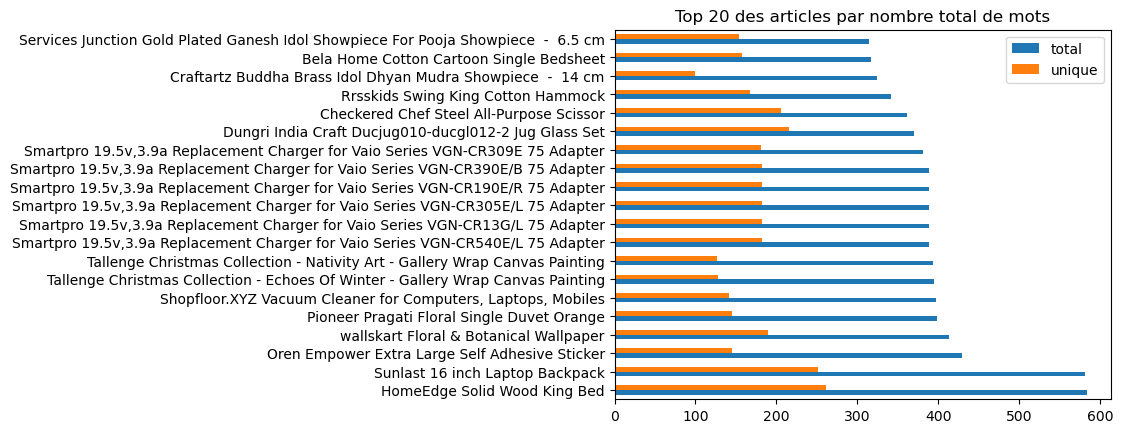

In [18]:
stats_df.sort_values(by='total', ascending=False).head(20).plot(
    kind='barh',
    title='Top 20 des articles par nombre total de mots'
)

Quelles sont les images des articles qui ont le champ lexical (vocabulaire) le plus riche?

<Axes: title={'center': 'Top 20 des articles par nombre total de mots'}>

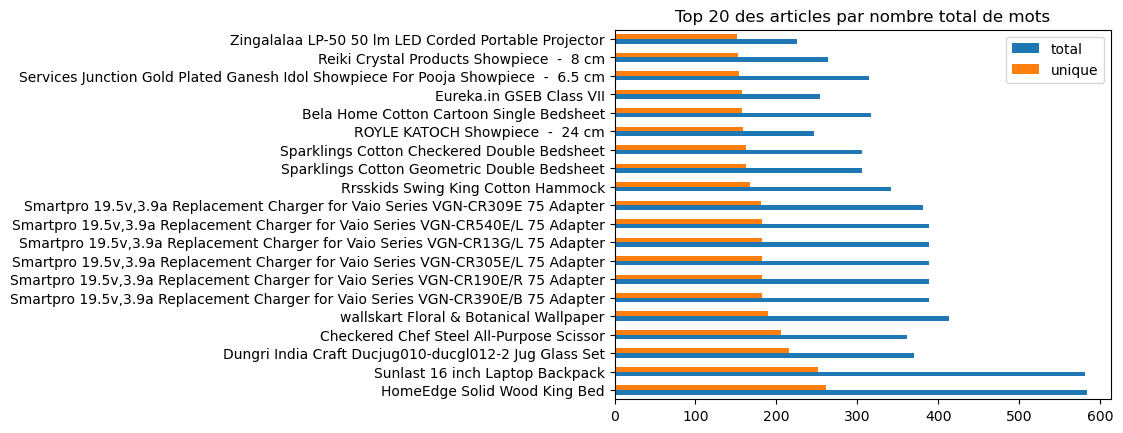

In [20]:
stats_df.sort_values(by='unique', ascending=False).head(20).plot(
    kind='barh',
    title='Top 20 des articles par nombre total de mots'
)

#### Nettoyez et normalisez les données

**Supprimer les stopwords**

Ce sont les mots très courants dans la langue étudiée ("et", "à", "le"... en français) qui n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. Il sont très fréquents et ralentissent notre travail : nous souhaitons donc les supprimer.

In [22]:
# On récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]

freq_totale.most_common(50)

[('of', 1751),
 ('for', 1436),
 ('the', 1369),
 ('and', 1332),
 ('to', 1058),
 ('in', 1047),
 ('rs', 911),
 ('only', 890),
 ('with', 843),
 ('on', 835),
 ('at', 714),
 ('a', 677),
 ('your', 656),
 ('is', 638),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('1', 554),
 ('cm', 543),
 ('day', 540),
 ('30', 498),
 ('flipkart', 481),
 ('com', 473),
 ('guarantee', 471),
 ('this', 444),
 ('it', 438),
 ('online', 396),
 ('features', 395),
 ('from', 382),
 ('specifications', 371),
 ('s', 365),
 ('you', 360),
 ('price', 352),
 ('watch', 330),
 ('color', 328),
 ('mug', 327),
 ('baby', 320),
 ('pack', 317),
 ('material', 312),
 ('set', 310),
 ('type', 304),
 ('cotton', 299),
 ('box', 292),
 ('general', 288),
 ('5', 286)]

On observe que dans les mots les plus fréquents, il peut y avoir des mots utiles dans une classification des articles. Par exemple, "baby", "mug".

In [24]:
freq_totale.most_common(30)

[('of', 1751),
 ('for', 1436),
 ('the', 1369),
 ('and', 1332),
 ('to', 1058),
 ('in', 1047),
 ('rs', 911),
 ('only', 890),
 ('with', 843),
 ('on', 835),
 ('at', 714),
 ('a', 677),
 ('your', 656),
 ('is', 638),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('1', 554),
 ('cm', 543),
 ('day', 540),
 ('30', 498),
 ('flipkart', 481),
 ('com', 473),
 ('guarantee', 471),
 ('this', 444)]

On peut cependant supprimer sans risque les 30 premiers mots les plus fréquents.

In [26]:
# On décide manière un peu arbitraire du nombre de mots les plus fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre de mots pour se rendre compte et avoir une meilleure heuristique. 
most_freq = list(zip(*freq_totale.most_common(30)))[0]

# On créé notre set de stopwords final qui cumule ainsi les 30 mots les plus fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent dans la librairie NLTK
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('english')))

Appelons la fonction pour calculer les stats, la frequence en supprimant les stopwords :

In [28]:
# Application de la fonction
freq, stats_df, corpora = ptt.freq_stats_for_description_without_stopwords(data, sw)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                                    total  unique
Elegance Polyester Multicolor Abstract Eyelet D...    158     107
Sathiyas Cotton Bath Towel                             67      43
Eurospa Cotton Terry Face Towel Set                   167      98
SANTOSH ROYAL FASHION Cotton Printed King sized...    122      64
Jaipur Print Cotton Floral King sized Double Be...    165      90
...                                                   ...     ...
Oren Empower Extra Large Self Adhesive Sticker        239     101
Wallmantra Large Vinyl Sticker Sticker                154      66
Uberlyfe Extra Large Pigmented Polyvinyl Films ...     20      12
Wallmantra Medium Vinyl Sticker Sticker                14       8
Uberlyfe Large Vinyl Sticker                           12       8

[1050 rows x 2 columns]


<Axes: title={'center': 'Top 20 des articles par nombre total de mots'}>

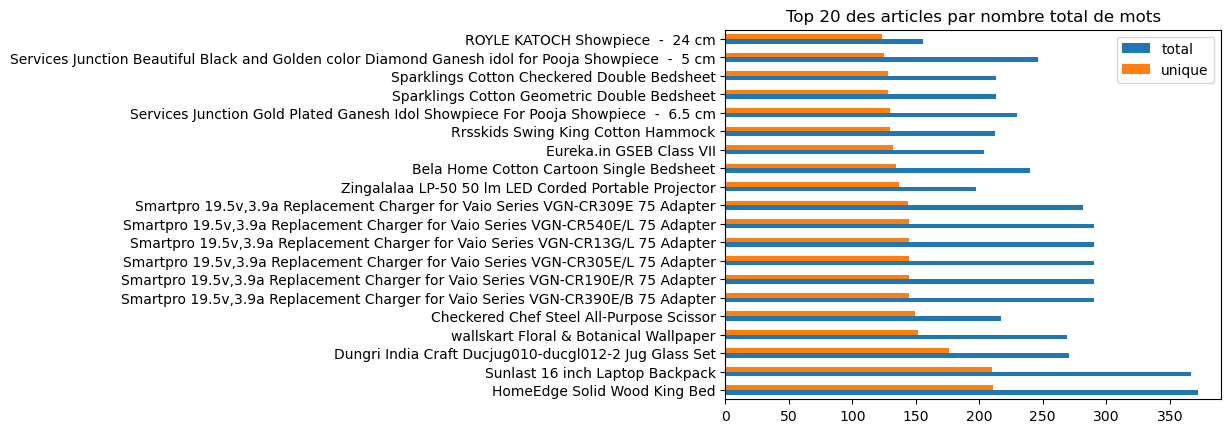

In [29]:
stats_df.sort_values(by='unique', ascending=False).head(20).plot(
    kind='barh',
    title='Top 20 des articles par nombre total de mots'
)

On observe quelques changements dans le classement.

**lemmatisation ou racinisation (stemming)**

Le processus de « lemmatisation » consiste à représenter les mots sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.

Il existe un autre processus qui exerce une fonction similaire qui s'appelle la racinisation(ou stemming en anglais). Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

La lemmatisation consiste donc à réduire un mot à sa forme de base (le lemme). Par exemple, "running" sera lemmatisé en "run" et "better" en "good". Pour ajouter la lemmatisation, nous allons utiliser WordNetLemmatizer de NLTK.

J'ai choisi la lemmatisation plutôt que le stemming car : 
- La réduction plus précise : la lemmatisation réduit les mots à leur lemme correct, c'est-à-dire la forme correcte d'un mot que l'on trouverait dans le dictionnaire. Cette approche prend en compte la grammaire et le contexte du mot. Il y aura moins de perte de sens.
- La réduction est donc moins agressive que celle réalisée avec le stemming.

In [32]:
# Application de la fonction
freq, stats_df, corpora = ptt.freq_stats_for_description_without_stopwords_and_with_lemmatizer(data, sw)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                                    total  unique
Elegance Polyester Multicolor Abstract Eyelet D...    159     106
Sathiyas Cotton Bath Towel                             67      43
Eurospa Cotton Terry Face Towel Set                   168      97
SANTOSH ROYAL FASHION Cotton Printed King sized...    122      64
Jaipur Print Cotton Floral King sized Double Be...    166      90
...                                                   ...     ...
Oren Empower Extra Large Self Adhesive Sticker        240      98
Wallmantra Large Vinyl Sticker Sticker                157      63
Uberlyfe Extra Large Pigmented Polyvinyl Films ...     22      14
Wallmantra Medium Vinyl Sticker Sticker                16      10
Uberlyfe Large Vinyl Sticker                           14      10

[1050 rows x 2 columns]


<Axes: title={'center': 'Top 20 des articles par nombre total de mots'}>

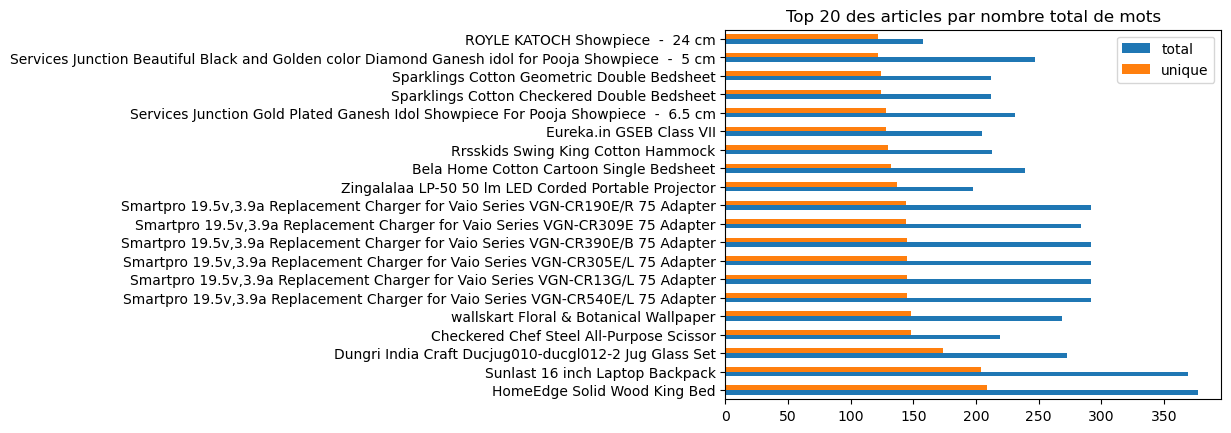

In [33]:
stats_df.sort_values(by='unique', ascending=False).head(20).plot(
    kind='barh',
    title='Top 20 des articles par nombre total de mots'
)

**Un peu d'analyse des fréquences de mots**

Quels sont les tokens les plus présents ?

In [35]:
# Appel de la fonction
most_common_words = ptt.get_most_common_words(freq)

# Afficher les 30 mots les plus fréquents
print("Top 30 des mots les plus fréquents :")
for word, count in most_common_words[:30]:
    print(f"{word}: {count}")

Top 30 des mots les plus fréquents :
r: 927
product: 864
price: 561
mug: 457
feature: 404
online: 396
specification: 379
color: 369
watch: 355
type: 325
baby: 321
pack: 319
material: 313
set: 311
cotton: 299
box: 297
general: 288
5: 288
design: 273
package: 269
sale: 262
analog: 262
number: 254
warranty: 252
quality: 245
3: 245
detail: 243
girl: 242
brand: 238
laptop: 234


La présence des chiffres 3, 2 et 5 est étrange.

Les tokens "girl", "laptop", "material", "mug" sont des tokens intéressants.

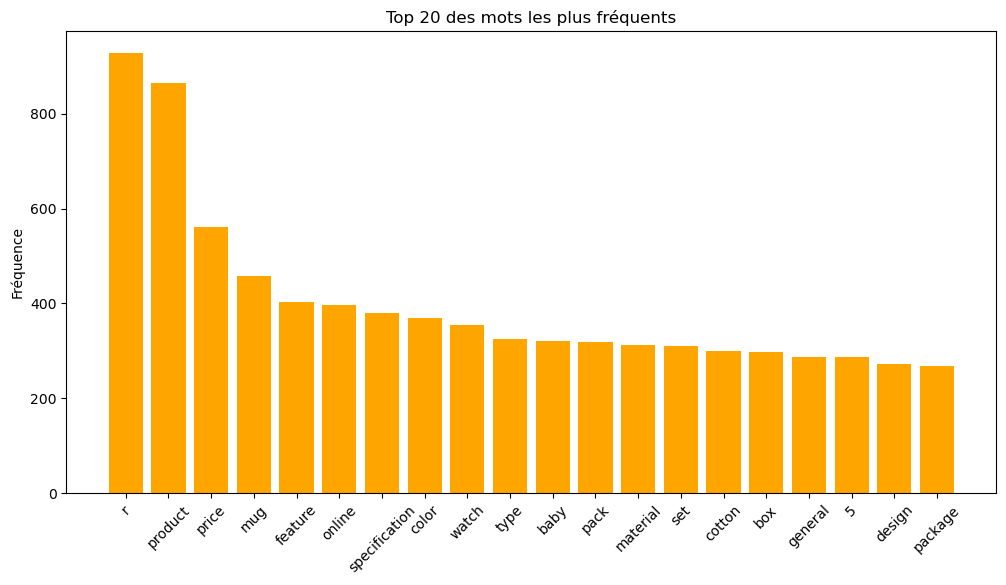

In [37]:
# Préparer les données pour le graphique
words, counts = zip(*most_common_words[:20])  # Top 20 mots
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='orange')
plt.xticks(rotation=45)
plt.title("Top 20 des mots les plus fréquents")
plt.ylabel("Fréquence")
plt.show()

Quels sont les tokens les moins présents ?

In [39]:
# Afficher les 30 mots les moins fréquents
print("Top 30 des mots les moins fréquents :")
for word, count in most_common_words[-30:]:
    print(f"{word}: {count}")

Top 30 des mots les moins fréquents :
smoothes: 1
shiny: 1
860: 1
771: 1
customization: 1
unisex: 1
marketing: 1
surgeon: 1
operate: 1
nursing: 1
clinic: 1
apron: 1
vastu: 1
aura: 1
negativity: 1
disintegrates: 1
disintegrating: 1
main: 1
rotate: 1
clockwise: 1
amplifies: 1
intention: 1
played: 1
deeper: 1
685: 1
1216: 1
730: 1
1143: 1
oren: 1
896: 1


Ces tokens sont présents une seul fois. Intérêt d'utiliser ou non les tokens présents une seule fois ?

In [41]:
nb_tokents_equal_1 = 0
for word, count in most_common_words:
    if count == 1:
        nb_tokents_equal_1 += 1
print("Nombre de tokens présents une seule fois :", nb_tokents_equal_1)

Nombre de tokens présents une seule fois : 1783


Visualisons la distribution des fréquences de tokens :

In [43]:
# Convertir la liste en DataFrame
df_most_common_words = pd.DataFrame(most_common_words, columns=["word", "frequency"])

df_most_common_words["frequency"].describe()

count    5529.000000
mean        9.810273
std        34.048807
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       927.000000
Name: frequency, dtype: float64

25% des tokens sont présents une seule fois.

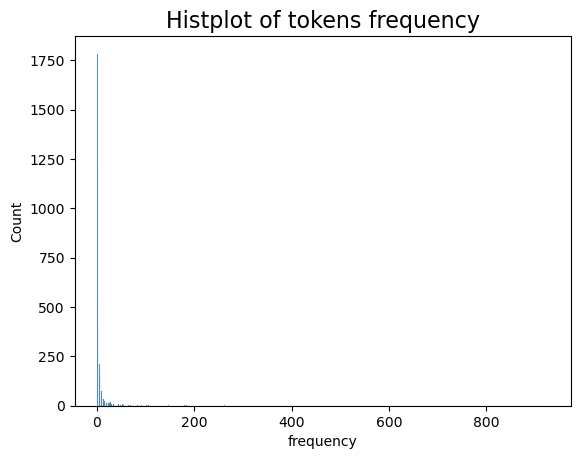

In [45]:
sns.histplot(data=df_most_common_words, x='frequency')
plt.title('Histplot of tokens frequency', fontsize=16)
plt.show()

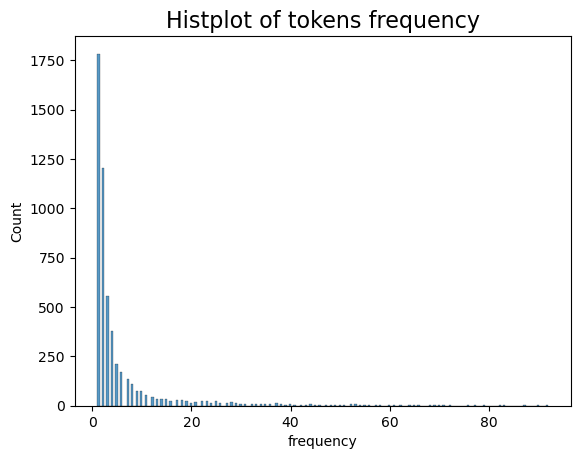

In [46]:
sample = df_most_common_words.loc[df_most_common_words['frequency'] < 100]
sns.histplot(data=sample, x='frequency')
plt.title('Histplot of tokens frequency', fontsize=16)
plt.show()

La distribution des fréquences de mots est très asymétrique.

**Supprimons les mots qui sont présents une seule fois**

Il n'y a pas un grand intérêt à conserver des mots qui seront vraisemblement supprimer dans l'étape de réduction des dimensions. Donc pour alléger les calculs, on peut les supprimer mainteant.

In [49]:
unique_tokens = []
for word, count in most_common_words:
    if count == 1:
        unique_tokens.append(word)
print("nombre de tokens unique à supprimer :", len(unique_tokens))

nombre de tokens unique à supprimer : 1783


Ajoutons cette liste de tokens aux stopwords existant, et rappelons la fonction :

In [51]:
# Application de la fonction
sw.update(unique_tokens)
freq, stats_df, corpora = ptt.freq_stats_for_description_without_stopwords_and_with_lemmatizer(data, sw)

# Affichage des résultats (total = nombre de mots)
print(stats_df)

                                                    total  unique
Elegance Polyester Multicolor Abstract Eyelet D...    147      94
Sathiyas Cotton Bath Towel                             65      41
Eurospa Cotton Terry Face Towel Set                   163      92
SANTOSH ROYAL FASHION Cotton Printed King sized...    118      60
Jaipur Print Cotton Floral King sized Double Be...    163      87
...                                                   ...     ...
Oren Empower Extra Large Self Adhesive Sticker        239      97
Wallmantra Large Vinyl Sticker Sticker                156      62
Uberlyfe Extra Large Pigmented Polyvinyl Films ...     22      14
Wallmantra Medium Vinyl Sticker Sticker                16      10
Uberlyfe Large Vinyl Sticker                           14      10

[1050 rows x 2 columns]


Récupérons la nouvelle fréquence des mots et affichons les 30 mots les moins fréquents :

In [53]:
most_common_words = ptt.get_most_common_words(freq)
df_most_common_words = pd.DataFrame(most_common_words, columns=["word", "frequency"])
df_most_common_words["frequency"].describe()

count    3746.000000
mean       14.003737
std        40.702955
min         2.000000
25%         2.000000
50%         4.000000
75%         9.000000
max       927.000000
Name: frequency, dtype: float64

In [54]:
# Afficher les 30 mots les moins fréquents
print("Top 30 des mots les moins fréquents :")
for word, count in most_common_words[-30:]:
    print(f"{word}: {count}")

Top 30 des mots les moins fréquents :
arranged: 2
alternatively: 2
reflectively: 2
cor: 2
greenery: 2
idea: 2
attach: 2
grease: 2
contamination: 2
pre: 2
lacquered: 2
cure: 2
recommend: 2
discourage: 2
certain: 2
brick: 2
stucco: 2
concrete: 2
suede: 2
squeeze: 2
helpful: 2
member: 2
deserves: 2
sweeping: 2
personalise: 2
receive: 2
final: 2
practice: 2
polyvinyl: 2
film: 2


**Supprimons les tokens avec des chiffres**

Combien de tokens uniquement numériques ?

In [56]:
numerical_tokens = []
for word, count in most_common_words:
    if word.isdigit():
        numerical_tokens.append(word)
print("Nombre de tokens numériques :", len(numerical_tokens))

Nombre de tokens numériques : 296


In [57]:
sw.update(numerical_tokens)
freq, stats_df, corpora = ptt.freq_stats_for_description_without_stopwords_and_with_lemmatizer(data, sw)

most_common_words = ptt.get_most_common_words(freq)
df_most_common_words = pd.DataFrame(most_common_words, columns=["word", "frequency"])
df_most_common_words["frequency"].describe()

count    3450.000000
mean       14.133333
std        41.420468
min         2.000000
25%         2.000000
50%         4.000000
75%         9.000000
max       927.000000
Name: frequency, dtype: float64

In [58]:
numerical_tokens = []
for word, count in most_common_words:
    if word.isdigit():
        numerical_tokens.append(word)
print("Nombre de tokens numériques :", len(numerical_tokens))

Nombre de tokens numériques : 0


**Conservons uniquement les mots anglais**

Pour cela utilisons le dictionnaire words de NLTK

In [60]:
freq, stats_df, corpora = ptt.process_text(data, sw, 'description')

most_common_words = ptt.get_most_common_words(freq)
df_most_common_words = pd.DataFrame(most_common_words, columns=["word", "frequency"])
df_most_common_words["frequency"].describe()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


count    2313.000000
mean       17.917423
std        48.298655
min         2.000000
25%         2.000000
50%         5.000000
75%        13.000000
max       927.000000
Name: frequency, dtype: float64

Regardons les mots les plus présents :

In [62]:
# Appel de la fonction
most_common_words = ptt.get_most_common_words(freq)

# Afficher les 30 mots les plus fréquents
print("Top 30 des mots les plus fréquents :")
for word, count in most_common_words[:30]:
    print(f"{word}: {count}")

Top 30 des mots les plus fréquents :
r: 927
product: 864
price: 561
mug: 457
feature: 404
specification: 379
color: 369
watch: 355
type: 325
baby: 321
pack: 319
material: 313
set: 311
cotton: 299
box: 297
general: 288
design: 273
package: 269
sale: 262
number: 254
warranty: 252
quality: 245
detail: 243
girl: 242
brand: 238
inch: 231
best: 230
model: 226
key: 224
ceramic: 219


On observe que le mot le plus féquent est "r". Une lettre seule n'a pas un grand intérêt dans notre cas. Mais en anglais il y a des mots d'une lettre comme "I" et "a". Donc on ne peut pas supprimer brutalement tous les mots d'une lettre.

*Le nettoyage est désormais terminé pour la description.*

### 1.1 - Prétraitement des données textes du product_name

Il s'agit de réaliser le pré traitement sur le nom des articles. C'est à dire les étapes suivantes :
- Tokénisation
- Lématisation
- Suppression des stop words
- Suppression des mots qui ne sont pas dans le dictionnaire anglais

Commençons par calculer les stats :

In [65]:
freq_product, stats_df_product, corpora_product = ptt.freq_stats_for_product_name(data)

Puis récupérons le comptage des mots globaux pour le product name :

In [67]:
most_common_words_product = ptt.get_most_common_words(freq_product)

Et enfin créons la liste des stopwords personnalisé :

In [69]:
sw_product = ptt.create_set_personal_stopwords(most_common_words_product, True, True)

**Nettoyage du product_name**

In [74]:
freq_product, stats_df_product, corpora_product = ptt.process_text(data, sw_product, 'product_name')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [76]:
most_common_words_product = ptt.get_most_common_words(freq_product)
df_most_common_words_product = pd.DataFrame(most_common_words_product, columns=["word", "frequency"])
df_most_common_words_product["frequency"].describe()

count    509.000000
mean       7.622790
std       14.270556
min        1.000000
25%        2.000000
50%        3.000000
75%        7.000000
max      151.000000
Name: frequency, dtype: float64

On observe moins de mots dans le product_name que dans la description.

**Regardons les mots les plus présents :**

In [79]:
# Afficher les 30 mots les plus fréquents
print("Top 30 des mots les plus fréquents :")
for word, count in most_common_words_product[:30]:
    print(f"{word}: {count}")

Top 30 des mots les plus fréquents :
watch: 151
set: 135
showpiece: 105
baby: 94
men: 78
ceramic: 78
mug: 76
girl: 71
boy: 68
cotton: 55
woman: 55
single: 45
double: 40
abstract: 39
blue: 35
light: 33
towel: 31
led: 31
multicolor: 29
printed: 29
l: 29
design: 28
floral: 27
black: 26
sticker: 26
blanket: 26
cell: 25
print: 24
cover: 24
gift: 23


*Nettoyage terminé pour le product_name*

### 1.2 Wordcloud - nuage de mots

**Description**

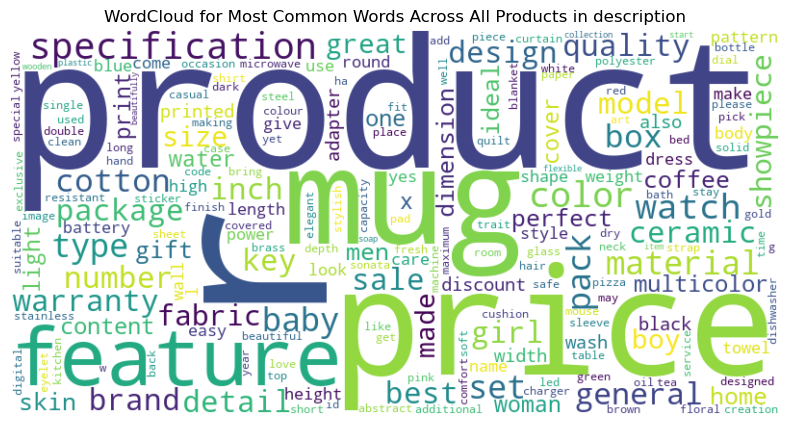

In [86]:
# Combiner les mots les plus fréquents
combined_frequencies = Counter()

# Ajouter chaque mot avec sa fréquence au Counter
for word, nb in most_common_words:
    combined_frequencies[word] += nb

# Générer le nuage de mots
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400,
    colormap='viridis'
).generate_from_frequencies(combined_frequencies)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Most Common Words Across All Products in description")
plt.show()

On observe des mots qui pourront éventuellement servir à la classificiation : mug, cotton, ceramic, water, material, wach, box, woman, girl,...

**Product_name**

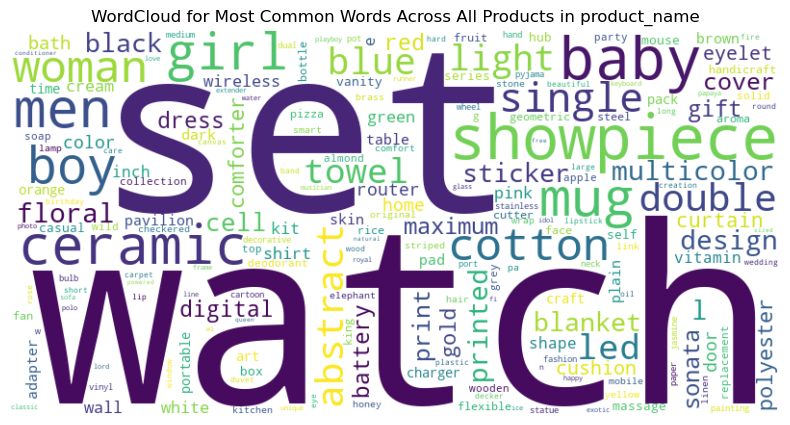

In [89]:
# Combiner les mots les plus fréquents
combined_frequencies = Counter()

# Ajouter chaque mot avec sa fréquence au Counter
for word, nb in most_common_words_product:
    combined_frequencies[word] += nb

# Générer le nuage de mots
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400,
    colormap='viridis'
).generate_from_frequencies(combined_frequencies)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Most Common Words Across All Products in product_name")
plt.show()

On observe la présence de mots communs entre la description et le product_name.

### 1.3 - Visualisation des descriptions nettoyées

**A quoi ressemble les descriptions des produits après le nettoyage ?**

Voici la situation avant nettoyage :

In [92]:
pd.set_option('display.max_colwidth', None)  # Afficher toute la largeur des colonnes
data[['product_name', 'description']].head(2)

,product_name,description
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester"
1,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel"


Voici la situation après nettoyage :

In [94]:
# Convertir le defaultdict en DataFrame et utiliser head()
corpora_df = pd.DataFrame(list(corpora.items()), columns=['product_name', 'description'])
corpora_df[['product_name', 'description']].head(2)

,product_name,description
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[key, feature, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain, elegance, polyester, multicolor, abstract, eyelet, door, curtain, height, pack, price, r, curtain, look, interior, curtain, made, high, quality, polyester, fabric, feature, eyelet, style, stitch, metal, ring, make, room, environment, curtain, ant, wrinkle, anti, shrinkage, elegant, give, home, bright, appeal, design, attention, sure, heart, contemporary, eyelet, curtain, slide, smoothly, draw, apart, first, thing, morning, welcome, bright, sun, ray, want, wish, good, morning, whole, world, draw, evening, create, special, moment, beauty, given, soothing, print, bring, home, elegant, curtain, light, room, get, right, amount, sunlight, specification, elegance, polyester, multicolor, abstract, eyelet, door, ...]"
1,Sathiyas Cotton Bath Towel,"[specification, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, feature, machine, washable, yes, material, cotton, design, self, design, general, brand, type, bath, towel, model, name, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, color, red, yellow, blue, size, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"


Si on regarde le nuage de mots pour le 1er produit :

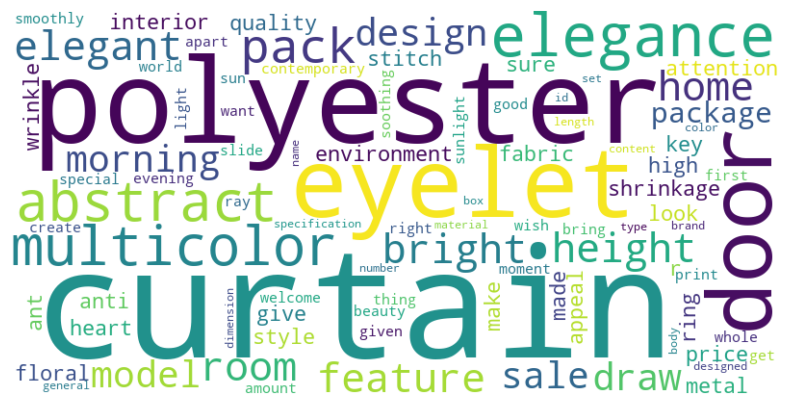

In [96]:
freq_first_product = {}
product_name = 'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

# Ajouter le Counter pour ce produit à freq_first_product
freq_first_product[product_name] = Counter(freq[product_name])

ptt.print_wordcloud(freq_first_product[product_name])

Si on regarde le nuage de mots pour le 2ème produit :

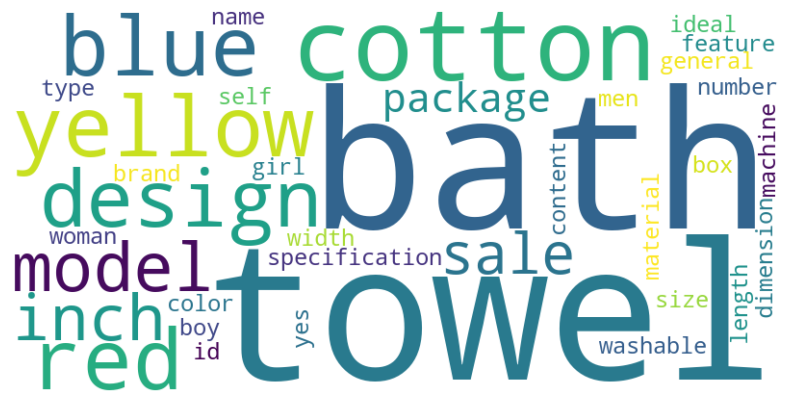

In [98]:
freq_second_product = {}
product_name = 'Sathiyas Cotton Bath Towel'

# Ajouter le Counter pour ce produit à freq_first_product
freq_second_product[product_name] = Counter(freq[product_name])

ptt.print_wordcloud(freq_second_product[product_name])

On voit clairement que les 2 produits ne sont pas décrits par les mêmes mots.

In [ ]:
pd.reset_option('display.max_colwidth')

### 1.4 - Visualisation des product_name nettoyés

**A quoi ressemble les product_name des articles après le nettoyage ?**

In [100]:
# Convertir le defaultdict en DataFrame et utiliser head()
corpora_df_product = pd.DataFrame(list(corpora_product.items()), columns=['product_name', 'product_name_tokens'])
corpora_df_product[['product_name', 'product_name_tokens']].head(2)

,product_name,product_name_tokens
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[elegance, polyester, multicolor, abstract, eyelet, door, curtain]"
1,Sathiyas Cotton Bath Towel,"[cotton, bath, towel]"


### 1.5 - Préparation de la variable catégorielle

Il s'agit de transformer la variable "product_category_tree" pour conserver uniquement le 1er niveau. On devrait obtenir ainsi 7 catégories.

In [ ]:
y = data['product_category_tree']
y

In [ ]:
# Appliquer la méthode split sur chaque élément de la colonne
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
y

Quelles sont les 7 catégories de 1er niveau ?

In [ ]:
y.unique()

### 1.5 - Préparons le dataframe pour l'étude de classification automatique

In [ ]:
corpora_df.head()

Tranformons la description en une unique chaîne de caractères :

In [ ]:
# Convertir la liste de mots en une chaîne de caractères
corpora_df['description'] = corpora_df['description'].apply(lambda x: ' '.join(x))
corpora_df.head()

In [ ]:
corpora_df.head()

In [ ]:
corpora_df.info()

## 2 - Etudier la faisabilité de classification en utilisant des méthodes NLP basiques